## Deja Brew
Introduction to Data Science (MATH 4100 / CS 5963), University of Utah

#### Final Project 
Ja-Rey Corcuera U1156525@utah.edu
Brianna Mendoza U1189033@utah.edu


## Background and Motivation
As college students, it seems that coffee has become a necessary fuel for many of us, worldwide. Though coffee may serve this purpose for students on a college campus, coffee can be more than that. What we hope to explore with this data is whether coffee has other significant characteristics, other than just caffeination. Can we explore its features such as acidity level, roast, place of origin, etc. to create a different relationship and experience with coffee? Do these things make a difference in the cup you drink? As people who drink coffee regularly, can there be more to it?

The goal of this data search is just to provide the people who drink coffee with more information. There is no ground-breaking, hidden information in this data, rather it is all information that we may already inherantly know just by experiencing coffee, but that we can now categorize into specific qualities that we enjoy the most. As a result, this data will allow the user to identify where they can find the perfect cup that has the most of what they love. 
We hope that what this data does the most is enhance the coffee-drinking experience of all who have access to it.

## Project Objectives
The core objectives of this project is quantify the many qualitative characteristics of coffee and thoroughly understand what they mean in a numerical sense. We want to identifying the important characteristics of coffee from around the world and understand the correlations, if there are any, between each one. Would we be able to recommend a coffee to a user based on desired characteristics, price, or origin? Can the agtron score predict the overall rating of the brew? What taste profiles do the highest rated coffees have, and is there a trend? Where does most coffee come from? Where does it go?
All of the questions can provide a more in depth understanding of each brew. Whether its amroma thats important to the drinker, or merely price, there may be a lot that results in the perfect poor. 

Coffee drinking, to most, is just a leisure activity, or a necessary start to their morning. This project can broaden a person’s knowledge of the beverage and heighten their experiences with it as a delicacy, not just as an energy booster.

## Background

**State-of-the-art: you could describe briefly other techniques that have been applied to your dataset or similar (but not exact) datasets; you could also talk about examples/applications where the same or similar data analysis techniques you choose in your project have been applied.** 

## Data
The data for this project was obtained from The Coffee Review website (https://www.coffeereview.com/review/?locations=na), where a group of coffee connoiseurs have taken the time since 1997 to thoroughly examine coffee from all over the world. We scraped this site for over 3000 reviews of coffee ground here in the United States.

While the data that we are working with comes from just the reviews, we also read the information on the rest of the website concerning how each coffee is rated, ethical considereations of how the coffee is sourced, and other endeavors The Coffee Review is a part of, to help better undertand their motive for creating this site and rating each coffee

Here's an example of one review from the website:
<img src="review.png" width="550">


## Ethical Considerations

TODO Preface: we don’t know how this coffee was sourced - but we assume it was ethical

## Data Processing

In [259]:
from urllib.request import Request, urlopen
import requests
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
import re
import random
import seaborn as sns
import statsmodels.formula.api as sm
import ssl
from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import geopandas as gpd
import geoplot
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')

### Webscraping

In [260]:
page_count = 286 # number of pages to scrape from (each page has 20 reviews)
coffee_df = pd.DataFrame()
counter = 0
run = False # Make true to start scraping

if run:
    # Loop through each webpage of reviews
    for page in range(1, page_count):

        url = "https://www.coffeereview.com/review/page/" + str(page) +  "/?locations=na"
        print("Opening page URL:", url)

        ssl._create_default_https_context = ssl._create_unverified_context
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        html = urlopen(req).read()

        soup = BeautifulSoup(html, 'html.parser')

        time.sleep(random.uniform(0.25, 0.75)) # Random delay between accessing pages

        # Loop through all reviews in the current webpage and find attributes
        for curr_review in soup.find_all(class_="review-template"):

            review_url = curr_review.find_all('a', href=True)[1]['href']
            #print("Opening review URL:", review_url)

            review_req = Request(review_url, headers={'User-Agent': 'Mozilla/5.0'})
            review_html = urlopen(review_req).read()

            review_soup = BeautifulSoup(review_html, 'html.parser')

            time.sleep(random.uniform(0.1, 0.3)) # Random delay between accessing reviews

            attributes = {}

            roaster = curr_review.find("p", class_="review-roaster").get_text()
            attributes["Roaster"] = roaster

            name = review_soup.find("h1", class_="review-title").get_text()
            attributes["Name"] = name

            rating = review_soup.find('span', class_="review-template-rating").get_text()
            attributes["Rating"] = rating

            i = 1
            curr_attribute = ""
            for tag in review_soup.find_all(class_="review-template-table")[0].find_all('td'):
                if i % 2 == 1:
                    curr_attribute = tag.get_text()[:-1]
                else:
                    attributes[curr_attribute] = tag.get_text()
                i = i + 1

            i = 1
            curr_attribute = ""
            for tag in review_soup.find_all(class_="review-template-table")[1].find_all('td'):
                if i % 2 == 1:
                    curr_attribute = tag.get_text()[:-1]
                else:
                    value = re.sub('\s+', '', tag.get_text())
                    attributes[curr_attribute] = value
                i = i + 1 

            # Append all attributes of this review to the dataframe
            coffee_df = coffee_df.append(attributes, ignore_index=True)

            counter = counter + 1
    
    print("Writing dataframe to csv file")
    coffee_df.to_csv('coffeereview.csv', index=False)
    coffee_df

Here We have scraped all of the data from the website. We use beautiful soup to sift through the HTML, identifying which tags contain the relevant information.  

### Data Cleanup & Wrangling

In [268]:
# Read dataframe from csv file
coffee_df =  pd.read_csv("coffeereview.csv")

# Extract both agtron readings from agtron attribute
coffee_df[["Agtron Ext", "Agtron Gnd"]] = coffee_df["Agtron"].str.split("/", expand=True)

# Drop reviews that don't record agtron values
coffee_df = coffee_df.drop(coffee_df[coffee_df.Agtron == "NA/NA"].index)

# Drop reviews that don't record origin location
#coffee_df = coffee_df.drop(coffee_df[coffee_df["Coffee Origin"] == "Not disclosed."].index)
coffee_df = coffee_df.drop(coffee_df[coffee_df["Coffee Origin"].str.contains("Not disclosed") == True].index)

# Drop reviews that don't record external agtron values
coffee_df = coffee_df.drop(coffee_df[coffee_df["Agtron Ext"] == ""].index)

# Drop unnecessary attributes
coffee_df = coffee_df.drop(columns = ["With Milk", "Acidity", "Acidity/Structure", "Agtron"])

# Drop all reviews with missing information
coffee_df = coffee_df.dropna()

# Filter out reviews that use non-US dollars
coffee_df = coffee_df[coffee_df["Est. Price"].str[0] == "$"]

# Filter out reviews that don't use ounces
coffee_df = coffee_df[(coffee_df["Est. Price"].str.contains("ounce") == True) | (coffee_df["Est. Price"].str.contains("oz") == True)]

# Filter out all other unordinary reviews
coffee_df = coffee_df[(coffee_df["Est. Price"].str.contains("CAD") == False) & (coffee_df["Est. Price"].str.contains("pounds") == False) & (coffee_df["Est. Price"].str.contains("online") == False) & (coffee_df["Est. Price"].str.contains("NTD") == False) & (coffee_df["Est. Price"].str.contains("g") == False) & (coffee_df["Est. Price"].str.contains("grams") == False)]

# Calculate dollars per ounce from estimated price
dollarsperoz_arr = []
for arr in coffee_df["Est. Price"].str.split("/"):
    dollarsperoz = float(arr[0].split("$")[1]) / float(arr[1].strip().split(" ")[0])
    dollarsperoz_arr.append(round(dollarsperoz, 2))

# Insert dollars per ounce column into datafame
coffee_df.insert(7, "DollarsPerOz", dollarsperoz_arr)

# Add a column that represents roast level as a numerical variable
coffee_df["Roast_Level_num"] = coffee_df["Roast Level"].map({'Light':0, 'Medium-Light': 1, 'Medium': 2, 'Medium-Dark': 3, 'Dark': 4, 'Very Dark': 4})

# Parse columns to appropriate data types
change_type = {
    'Rating': int,
    'DollarsPerOz': float,
    'Aroma': int,
    'Body': int,
    'Flavor': int,
    'Aftertaste': int,   
    "Agtron Ext": int,
    "Agtron Gnd": int,
    "Roast_Level_num": int
     }

coffee_df = coffee_df.astype(change_type).reset_index(drop=True)
coffee_df

Roaster  \
0                          Paradise Roasters   
1                              SkyTop Coffee   
2                      Jaunt Coffee Roasters   
3                            Magnolia Coffee   
4                              SkyTop Coffee   
5                               Old Soul Co.   
6                        JBC Coffee Roasters   
7                  Nostalgia Coffee Roasters   
8                        JBC Coffee Roasters   
9                        JBC Coffee Roasters   
10                 Nostalgia Coffee Roasters   
11                       JBC Coffee Roasters   
12                             Tipico Coffee   
13                          Chaos Coffee Co.   
14                             Tipico Coffee   
15                             Tipico Coffee   
16                 Bird Rock Coffee Roasters   
17                         Paradise Roasters   
18                            Monarch Coffee   
19                         Paradise Roasters   
20                         Paradise Roasters   
21                         Paradise Roasters   
22                         Paradise Roasters   
23                            Monarch Coffee   
24                            Monarch Coffee   
25                         Paradise Roasters   
26                 Oak & Bond Coffee Company   
27                 Oak & Bond Coffee Company   
28                          A&E Coffee & Tea   
29                     Jaunt Coffee Roasters   
30                          A&E Coffee & Tea   
31                          A&E Coffee & Tea   
32                       JBC Coffee Roasters   
33                       JBC Coffee Roasters   
34                    Hula Daddy Kona Coffee   
35                Red Rooster Coffee Roaster   
36                Red Rooster Coffee Roaster   
37                     Drink Coffee Do Stuff   
38                        Battlecreek Coffee   
39                         Metropolis Coffee   
40                              Old Soul Co.   
41                  Charlotte Coffee Company   
42                 Nostalgia Coffee Roasters   
43                 Succulent Coffee Roasters   
44              Battle Creek Coffee Roasters   
45                         Three Keys Coffee   
46                       JBC Coffee Roasters   
47                      Kona Love Coffee Co.   
48                      Kona Love Coffee Co.   
49                               Cafe Kreyol   
50                               Cafe Kreyol   
51                               Cafe Kreyol   
52                               Cafe Kreyol   
53                               Cafe Kreyol   
54                       JBC Coffee Roasters   
55                       JBC Coffee Roasters   
56                           Jackrabbit Java   
57                       JBC Coffee Roasters   
58                       JBC Coffee Roasters   
59                       JBC Coffee Roasters   
60                           Jackrabbit Java   
61                         Paradise Roasters   
62                  RamsHead Coffee Roasters   
63                  RamsHead Coffee Roasters   
64             Conscious Cup Coffee Roasters   
65             Conscious Cup Coffee Roasters   
66                             modcup coffee   
67                    Corvus Coffee Roasters   
68                             modcup coffee   
69                    Corvus Coffee Roasters   
70                           Folklore Coffee   
71                         Paradise Roasters   
72                       JBC Coffee Roasters   
73                      Old World Coffee Lab   
74                         Paradise Roasters   
75                      Old World Coffee Lab   
76                      Old World Coffee Lab   
77                      Old World Coffee Lab   
78                       JBC Coffee Roasters   
79                         Paradise Roasters   
80                         Paradise Roasters   
81                       JBC Coffee Roasters   
82                 Bird Rock Coffee Roasters   
83   

Here the data is cleaned: columns are added and dropped. There were a few reviews that did not contain all the information that we needed from them, so they were dropped. For example, some reviews did not contain agtron levels or places of origin, so they were dropped. We understand that dropping these does limit, in some sense, the story we are able to tell about each roast, but there were so little dropped in comparison to the rest of the reviews, that it would not affect the bigger picture. 


From each review, there were some attributes in the ratings that we did not feel were relevant, or that didn't show up often enought to take into account, things like how the coffee tasted with milk, or the acidity structure. This seemed less likely to impact the overall review of each roast.


In order to keep the data at bay, we restricted our data set to only roasts that were sold in U.S. dollars, as to make other calculations easy and to make the data easier to understand. After reducing to only the roasts sold in the U.S., each price was normalized to price per ounce. Using this data, we can see the average price each ounce of coffee is and calculate a general value with its price and rating. This will allow us to identify which coffees have the highest rating for the lowest prices. This may be important to a consumer. 


We also converted the roast level to integer representations to be able to numerically integrate them into other regressioins, plots, etc. Each roast level was assigned a number between 0 and 4, light being 0, and dark being 4. 


Lastly, we ensured that all the necessary values were converted to floats so that they would be usable throughout the project. 

In [269]:
# Filter out reviews where coffee origin location is unknown
countries_df =  pd.read_csv("world.csv")
countries = countries_df["en"].values

count = 0
for origin in coffee_df["Coffee Origin"].str.split(","):
    count = count + 1
    found = False
    for name in origin:
        for country in countries:
            if country.lower() in name.lower():
                found = True
                coffee_df.loc[count-1, "Coffee Origin"]=country
                break
                
        if found == True:
            break

    if found == False:
        coffee_df.loc[count-1, "Coffee Origin"]="NA"

coffee_df = coffee_df.drop(coffee_df[coffee_df["Coffee Origin"]== "NA"].index).reset_index(drop=True)

In [270]:
# Add lat/long coords of origin country 
coffee_df["Latitude"] = ""
coffee_df["Longitude"] = ""
latlong_df =  pd.read_csv("latlongcountries.csv")
countries = latlong_df["Country"]

count = 0
for origin in coffee_df["Coffee Origin"]:
    count = count + 1
    found = False

    for country in countries:
        if country.lower() == origin.lower():
            lat = latlong_df[latlong_df.Country == country].Latitude.values[0]
            long = latlong_df[latlong_df.Country == country].Longitude.values[0]

            coffee_df.loc[count-1, "Latitude"]=lat
            coffee_df.loc[count-1, "Longitude"]=long

            found = True
            break
            
    if found == False:
            coffee_df.loc[count-1, "Latitude"]=0
            coffee_df.loc[count-1, "Longitude"]=0

In order to effectively portray our categorical data, the place of origin, we were able to find a csv file with the latititude and longitude of every country in the world, and wer were able to map these locations to places of origin of each of the coffee. The data is merely loaded here but is used effectively further down in the project. 

In [271]:
# Filter out reviews where roaster location is unknown or not in the U.S.
states_df =  pd.read_csv("states.csv")
states = states_df["State"].values

count = 0
for location in coffee_df["Roaster Location"].str.split(","):
    count = count + 1
    found = False
    for name in location:
        for state in states:
            if state.lower() in name.lower():
                found = True

                coffee_df.loc[count-1, "Roaster Location"]=state
                break
                
        if found == True:
            break

    if found == False:
        coffee_df.loc[count-1, "Roaster Location"]="NA"

coffee_df = coffee_df.drop(coffee_df[coffee_df["Roaster Location"]== "NA"].index).reset_index(drop=True)
coffee_df = coffee_df.drop(coffee_df[coffee_df["Agtron Ext"] > 200].index)

If location was not available in any given review, that review was dropped. 

In [272]:
# Write cleaned dataframe to csv
coffee_df.to_csv('coffeereview_cleaned.csv', index=False)
coffee_df

Roaster  \
0                          Paradise Roasters   
1                              SkyTop Coffee   
2                      Jaunt Coffee Roasters   
3                            Magnolia Coffee   
4                              SkyTop Coffee   
5                               Old Soul Co.   
6                        JBC Coffee Roasters   
7                  Nostalgia Coffee Roasters   
8                        JBC Coffee Roasters   
9                        JBC Coffee Roasters   
10                 Nostalgia Coffee Roasters   
11                       JBC Coffee Roasters   
12                             Tipico Coffee   
13                          Chaos Coffee Co.   
14                             Tipico Coffee   
15                             Tipico Coffee   
16                 Bird Rock Coffee Roasters   
17                         Paradise Roasters   
18                            Monarch Coffee   
19                         Paradise Roasters   
20                         Paradise Roasters   
21                         Paradise Roasters   
22                         Paradise Roasters   
23                            Monarch Coffee   
24                            Monarch Coffee   
25                         Paradise Roasters   
26                 Oak & Bond Coffee Company   
27                 Oak & Bond Coffee Company   
28                          A&E Coffee & Tea   
29                     Jaunt Coffee Roasters   
30                          A&E Coffee & Tea   
31                          A&E Coffee & Tea   
32                       JBC Coffee Roasters   
33                       JBC Coffee Roasters   
34                    Hula Daddy Kona Coffee   
35                Red Rooster Coffee Roaster   
36                     Drink Coffee Do Stuff   
37                        Battlecreek Coffee   
38                              Old Soul Co.   
39                  Charlotte Coffee Company   
40                 Nostalgia Coffee Roasters   
41                 Succulent Coffee Roasters   
42              Battle Creek Coffee Roasters   
43                         Three Keys Coffee   
44                       JBC Coffee Roasters   
45                      Kona Love Coffee Co.   
46                      Kona Love Coffee Co.   
47                               Cafe Kreyol   
48                               Cafe Kreyol   
49                               Cafe Kreyol   
50                               Cafe Kreyol   
51                               Cafe Kreyol   
52                       JBC Coffee Roasters   
53                       JBC Coffee Roasters   
54                           Jackrabbit Java   
55                       JBC Coffee Roasters   
56                       JBC Coffee Roasters   
57                       JBC Coffee Roasters   
58                           Jackrabbit Java   
59                         Paradise Roasters   
60                  RamsHead Coffee Roasters   
61                  RamsHead Coffee Roasters   
62             Conscious Cup Coffee Roasters   
63             Conscious Cup Coffee Roasters   
64                             modcup coffee   
65                    Corvus Coffee Roasters   
66                             modcup coffee   
67                    Corvus Coffee Roasters   
68                           Folklore Coffee   
69                         Paradise Roasters   
70                       JBC Coffee Roasters   
71                      Old World Coffee Lab   
72                         Paradise Roasters   
73                      Old World Coffee Lab   
74                      Old World Coffee Lab   
75                      Old World Coffee Lab   
76                       JBC Coffee Roasters   
77                         Paradise Roasters   
78                         Paradise Roasters   
79                       JBC Coffee Roasters   
80                 Bird Rock Coffee Roasters   
81                     Jaunt Coffee Roasters   
82                              Revel Coffee   
83   

### Analysis

We begin our analysis here. Creating a data frame of the cleaned csv, we are able to both numerically and visusally represent our data. We are able to see what columns are in our data frame, we can see the numerical correlation between each of the paramters, we can load a visusal representation of each correlation through a heat map, and we can see how each parameter relates to the other through a pair plot. 
We can see individual relationships between each paramter, along with a general, big-picture relation overall. 

In [275]:
coffee_df = pd.read_csv("coffeereview_cleaned.csv")

In [276]:
coffee_df.corr()

Rating  DollarsPerOz     Aroma      Body    Flavor  \
Rating           1.000000      0.329556  0.701026  0.603004  0.771296   
DollarsPerOz     0.329556      1.000000  0.229038  0.235352  0.237736   
Aroma            0.701026      0.229038  1.000000  0.293367  0.514443   
Body             0.603004      0.235352  0.293367  1.000000  0.337392   
Flavor           0.771296      0.237736  0.514443  0.337392  1.000000   
Aftertaste       0.667192      0.211672  0.277910  0.214117  0.432015   
Agtron Ext       0.437326      0.154040  0.315289  0.275279  0.371765   
Agtron Gnd       0.430982      0.178103  0.310378  0.309542  0.332696   
Roast_Level_num -0.404929     -0.170785 -0.294733 -0.278889 -0.316592   
Latitude         0.035314      0.186688  0.040481  0.038294  0.026619   
Longitude        0.037572     -0.241745  0.041328 -0.006037  0.049468   

                 Aftertaste  Agtron Ext  Agtron Gnd  Roast_Level_num  \
Rating             0.667192    0.437326    0.430982        -0.404929   
DollarsPerOz       0.211672    0.154040    0.178103        -0.170785   
Aroma              0.277910    0.315289    0.310378        -0.294733   
Body               0.214117    0.275279    0.309542        -0.278889   
Flavor             0.432015    0.371765    0.332696        -0.316592   
Aftertaste         1.000000    0.267624    0.245049        -0.229990   
Agtron Ext         0.267624    1.000000    0.814959        -0.852307   
Agtron Gnd         0.245049    0.814959    1.000000        -0.901188   
Roast_Level_num   -0.229990   -0.852307   -0.901188         1.000000   
Latitude           0.003494    0.087356    0.081215        -0.078030   
Longitude          0.011000   -0.062527   -0.049707         0.050103   

                 Latitude  Longitude  
Rating           0.035314   0.037572  
DollarsPerOz     0.186688  -0.241745  
Aroma            0.040481   0.041328  
Body             0.038294  -0.006037  
Flavor           0.026619   0.049468  
Aftertaste       0.003494   0.011000  
Agtron Ext       0.087356  -0.062527  
Agtron Gnd       0.081215  -0.049707  
Roast_Level_num -0.078030   0.050103  
Latitude         1.000000  -0.458813  
Longitude       -0.458813   1.000000

Running the correlations for each parameter lets us know which characteristics have relationships. We can see that roast level and agtron grade after its ground have a strong negative correlation. This imples that a longer roast has a relationshop with the color of the bean. Longer roasting results in a darker bean. The less time it is spent roasting, the lighter the bean. This is definitely common sense, but we can see that the data supports this. But let us examine another correlation that maybe isn't so straight forward. The correlation between Aroma and rating is fairly strong and positive. This tells us that the higher the aroma, the higher the rating. Why could this be?

<AxesSubplot:>

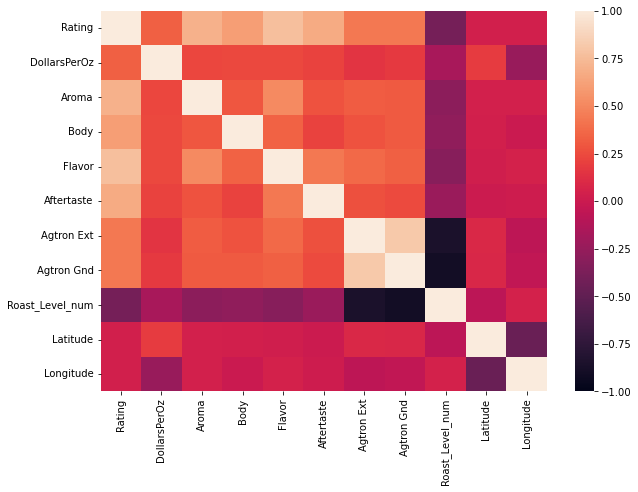

In [52]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(data = coffee_df.corr(), vmin = -1, vmax = 1)

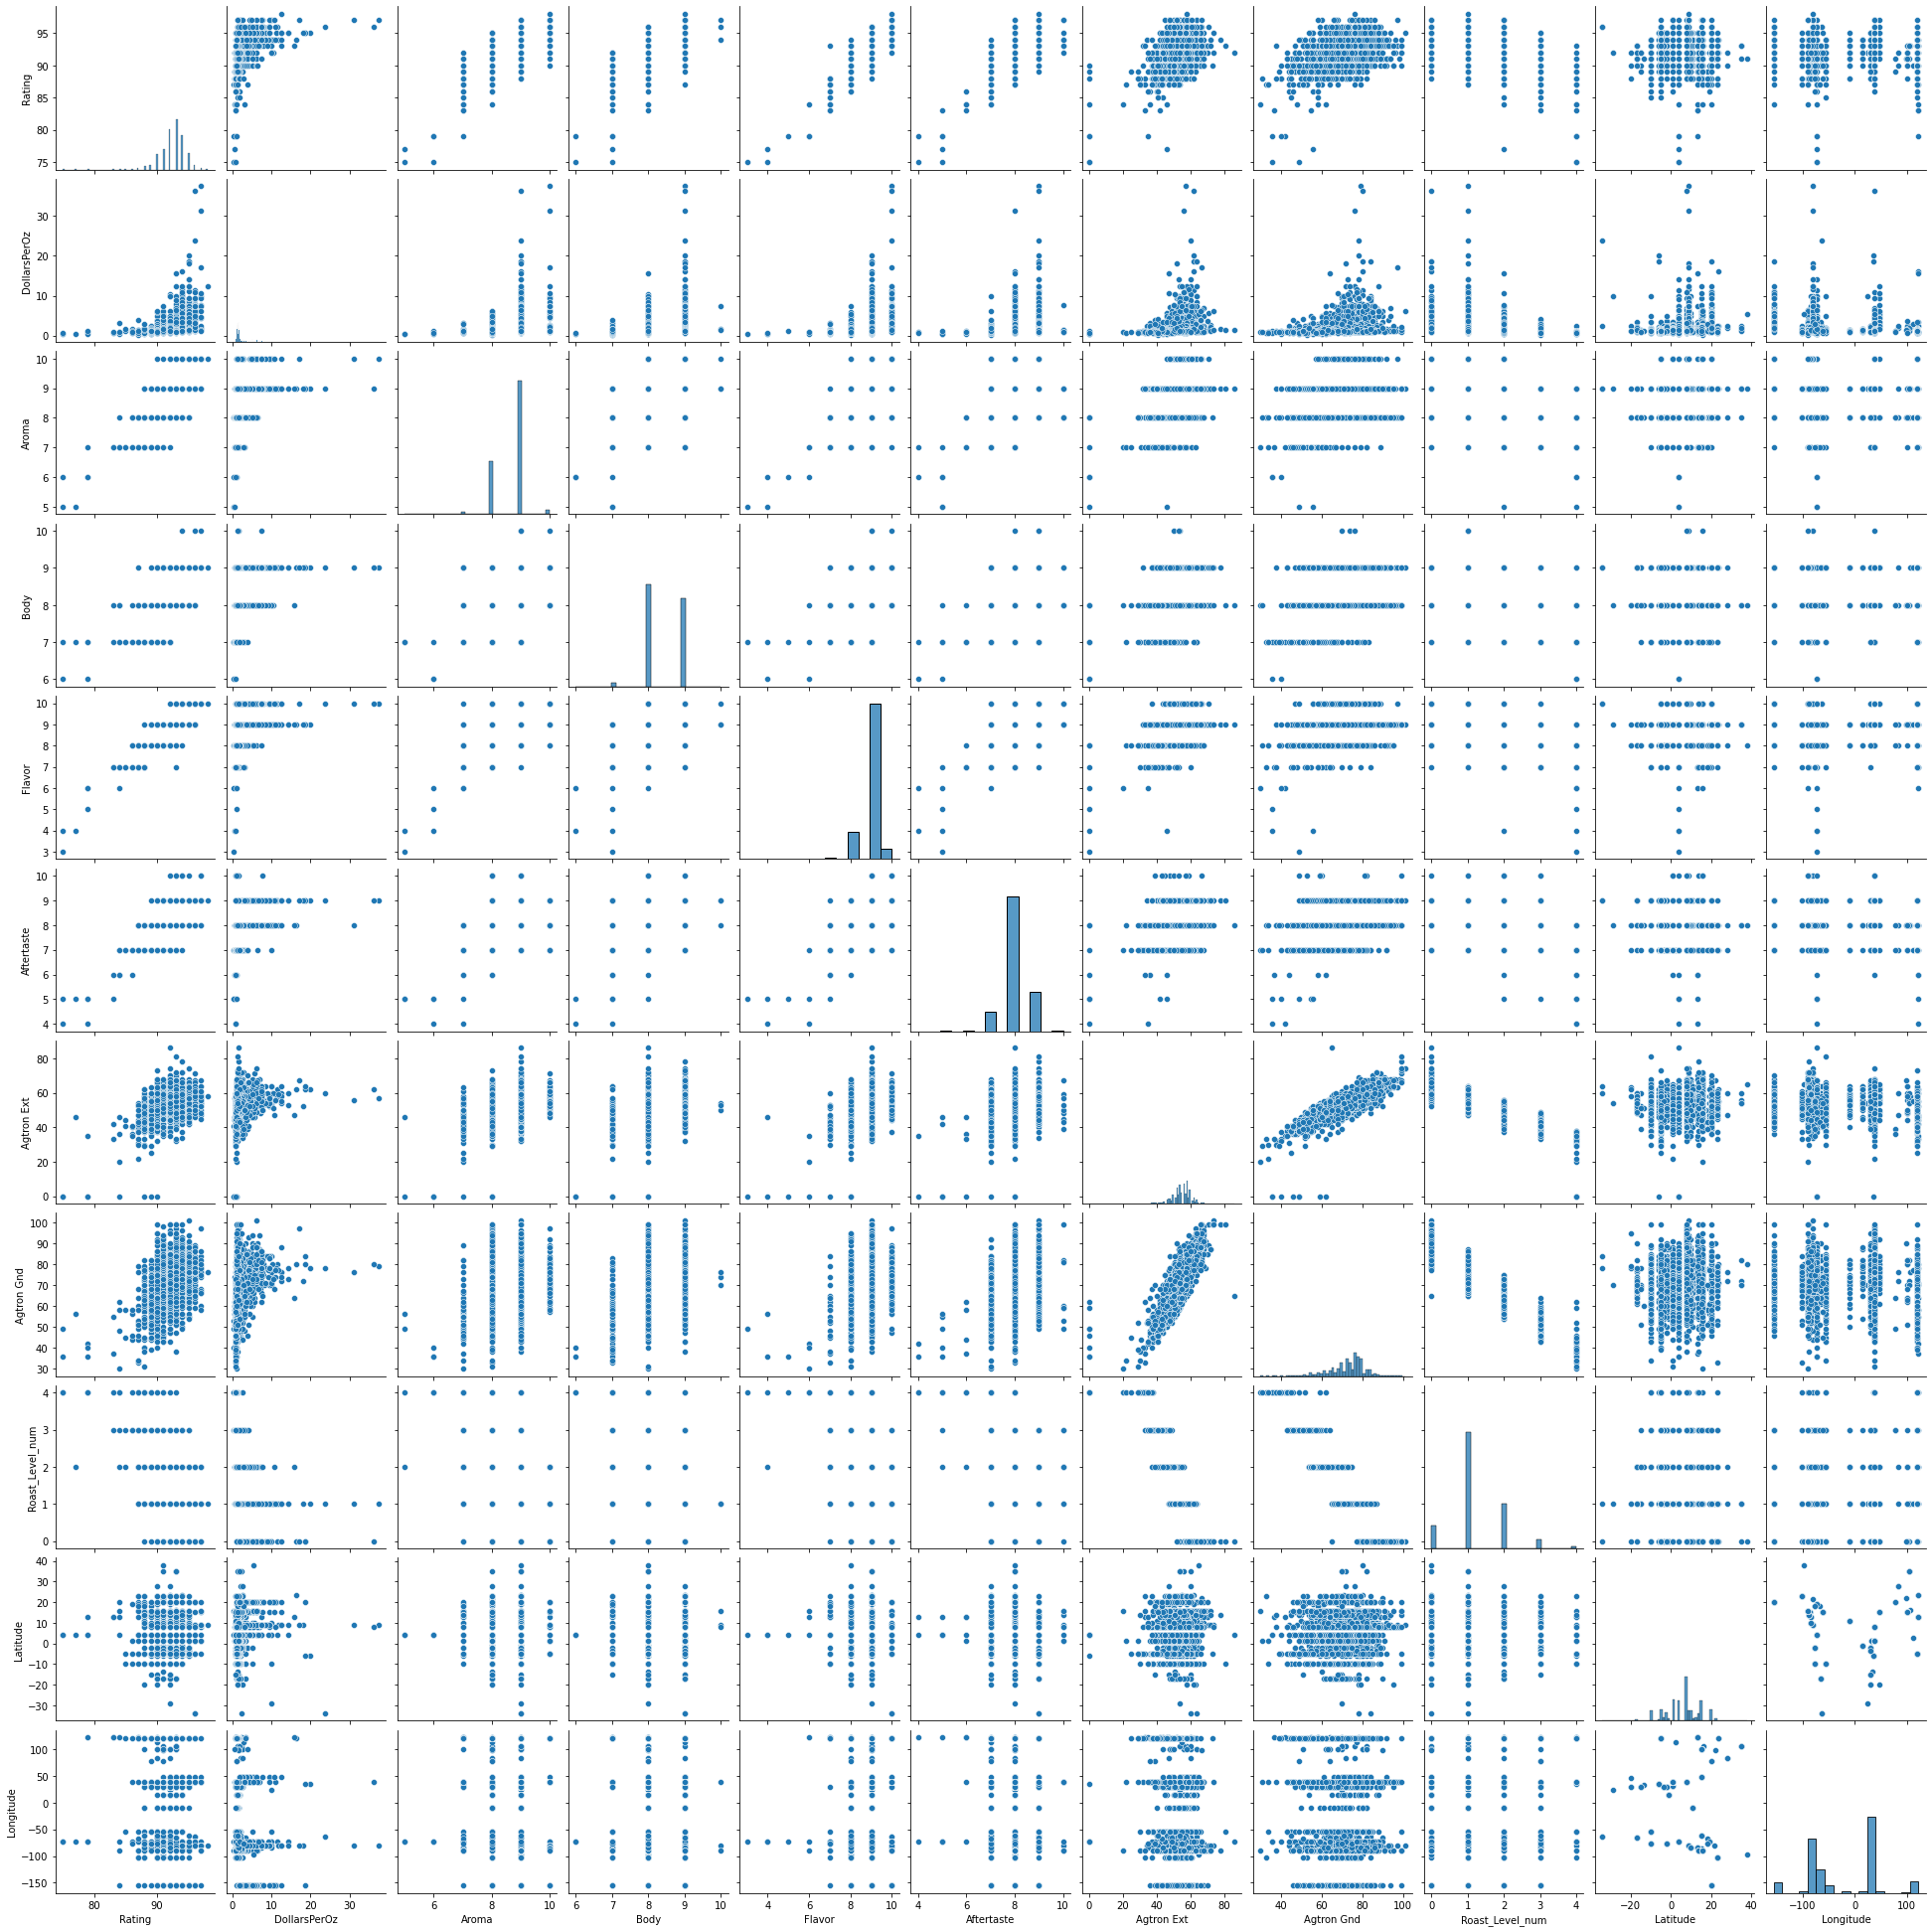

In [53]:
sns.pairplot(coffee_df)

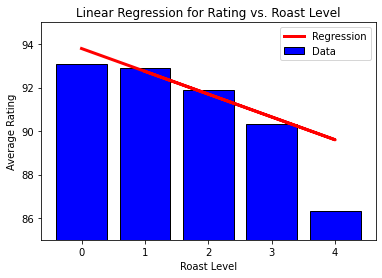

Equation: -1.05x + 93.8


In [277]:
rating_roast_ols = sm.ols(formula="Rating ~ Roast_Level_num", data=coffee_df).fit()
rating_roast_ols.summary()
params = rating_roast_ols.params

bar_dict = {}
for i in range(5):
    roast_df = coffee_df[coffee_df["Roast_Level_num"] == i]
    bar_dict[i] = roast_df["Rating"].mean()

names = list(bar_dict.keys())
values = list(bar_dict.values())

plt.bar(range(len(bar_dict)), values, tick_label=names, color='blue', edgecolor='black')
plt.plot(coffee_df['Roast_Level_num'],rating_roast_ols.predict(),color='red',linewidth=3)
plt.ylim([85, 95])
plt.xlabel('Roast Level')
plt.ylabel('Average Rating')
plt.title("Linear Regression for Rating vs. Roast Level")
plt.legend(["Regression", "Data"])
plt.show()
params[0]
params[1]
print("Equation: " + str(round(params[1], 2)) + "x + " + str(round(params[0], 2)))

Equation: 1.67 ln(x) + 91.67


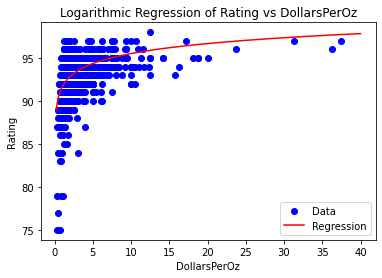

In [278]:
# Exploring Rating and DollarsPerOz
quad_model = np.poly1d(np.polyfit(np.log(coffee_df["DollarsPerOz"]), coffee_df["Rating"], 1))
plt.scatter(coffee_df["DollarsPerOz"], coffee_df["Rating"], color='blue');
x = np.linspace(-5, 40, 200)
plt.plot(x, quad_model(np.log(x)), 'r');
plt.title("Logarithmic Regression of Rating vs DollarsPerOz")
plt.xlabel("DollarsPerOz")
plt.ylabel("Rating")
plt.legend(["Data", "Regression"])
print("Equation: " + str(round(quad_model[1], 2)) + " ln(x) + " + str(round(quad_model[0], 2)))

In [66]:
# Case study on top X rated coffees?
N = 10
topN = coffee_df.nlargest(N, "Rating")

top_coffees = coffee_df.sort_values(by="Rating",ascending=False)

top_coffees
topN

Roaster  \
440             Equator Coffees   
17            Paradise Roasters   
111           Paradise Roasters   
206  Barrington Coffee Roasting   
445         JBC Coffee Roasters   
747   Dragonfly Coffee Roasters   
801         JBC Coffee Roasters   
802         JBC Coffee Roasters   
874   Dragonfly Coffee Roasters   
902   Bird Rock Coffee Roasters   

                                                  Name  Rating  \
440                          Finca Sophia Gesha Washed      98   
17              Colombia Finca El Paraiso Geisha Letty      97   
111                                  Mama Cata Mokkita      97   
206                         Testi Ayla Double Ethiopia      97   
445                            Ardent Ethiopia Natural      97   
747  Washed Geisha Hacienda La Esmeralda Jaramillo ...      97   
801                                       Rukera Kenya      97   
802                                    Rukera Espresso      97   
874              Kenya Karindundu AA Small Lot Reserve      97   
902                    Panama Ninety Plus Perci Lot 50      97   

    Roaster Location Coffee Origin   Roast Level  \
440       California        Panama  Medium-Light   
17         Minnesota      Colombia         Light   
111        Minnesota        Panama  Medium-Light   
206    Massachusetts      Ethiopia         Light   
445        Wisconsin      Ethiopia  Medium-Light   
747         Colorado        Panama  Medium-Light   
801        Wisconsin         Kenya  Medium-Light   
802        Wisconsin         Kenya  Medium-Light   
874         Colorado         Kenya  Medium-Light   
902       California        Panama  Medium-Light   

                                 Est. Price  DollarsPerOz   Review Date  \
440                         $50.00/4 ounces         12.50  November2020   
17                          $40.00/4 ounces         10.00  February2022   
111                        $150.00/4 ounces         37.50  November2021   
206                        $54.95/12 ounces          4.58    August2021   
445                         $35.00/8 ounces          4.38  November2020   
747  $125.00/4 ounces; limited availability         31.25  November2019   
801                        $21.20/12 ounces          1.77      July2019   
802                        $21.20/12 ounces          1.77      July2019   
874                        $18.00/12 ounces          1.50  February2019   
902                         $60.00/8 ounces          7.50   January2019   

     Aroma  Body  Flavor  Aftertaste  Agtron Ext  Agtron Gnd  Roast_Level_num  \
440     10     9      10           9          58          76                1   
17      10     9      10           9          64          84                0   
111     10     9      10           9          57          79                1   
206      9     9      10           9          64          86                0   
445     10     9      10           9          57          77                1   
747     10     9      10           8          56          76                1   
801     10     9      10           9          54          78                1   
802     10     9      10           9          54          78                1   
874     10     9      10           9          54          78                1   
902     10    10      10           9          50          74                1   

     Latitude  Longitude  
440       9.0      -80.0  
17        4.0      -72.0  
111       9.0      -80.0  
206       8.0       38.0  
445       8.0       38.0  
747       9.0      -80.0  
801       1.0       38.0  
802       1.0       38.0  
874       1.0       38.0  
902       9.0      -80.0

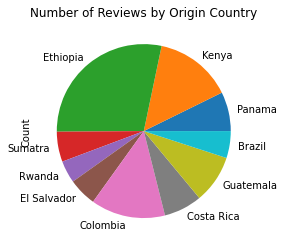

In [213]:
# Looking at the top N most common coffee origin countries
N = 10
topN_df = pd.DataFrame()

topN = coffee_df["Coffee Origin"].value_counts().nlargest(N).index.tolist()

for country in topN:
    country_df = coffee_df[coffee_df["Coffee Origin"] == country]
    country_dict = {"Country":country, "Count":len(country_df.index),"Mean Rating":country_df.Rating.mean(), "Mean Agtron Ext": country_df["Agtron Ext"].mean(), "Mean Agtron Gnd": country_df["Agtron Gnd"].mean(), "Mean Dollars/Oz":country_df["DollarsPerOz"].mean()}
    topN_df = topN_df.append(country_dict, ignore_index=True)

topN_df = topN_df.sort_values(by=['Mean Rating'], ascending=False)
    
topN_df = topN_df.set_index("Country")
topN_df.plot.pie(y="Count", legend=None);
plt.title("Number of Reviews by Origin Country");


### Global Analysis

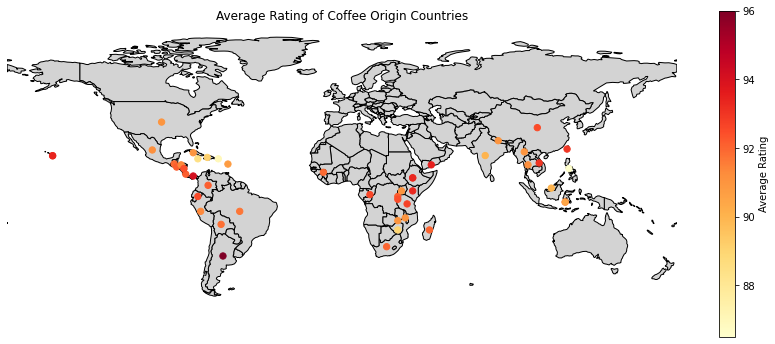

In [279]:
# Collecting all coffee origin countries and putting characteristics into a dataframe
origins_df = pd.DataFrame()
latlong_df =  pd.read_csv("latlongcountries.csv")

countries = coffee_df["Coffee Origin"].value_counts().index.tolist()

for country in countries:
    country_df = coffee_df[coffee_df["Coffee Origin"] == country]
    lat = latlong_df[latlong_df.Country == country].Latitude.values[0]
    long = latlong_df[latlong_df.Country == country].Longitude.values[0]

    country_dict = {"Country":country, "Count":len(country_df.index),"Average Rating":country_df.Rating.mean(), "Average Agtron Ext": country_df["Agtron Ext"].mean(), "Average Dollars/Oz":country_df["DollarsPerOz"].mean(), "Latitude": lat, "Longitude": long}
    origins_df = origins_df.append(country_dict, ignore_index=True)

fig, ax = plt.subplots(figsize=(15,6))
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries = countries[countries.name != "Antarctica"]

geoplot.polyplot(countries,facecolor='lightgray', ax=ax)

# Filter out countries that have less than 5 reviews from there
origins_df_filt = origins_df[origins_df["Count"] >= 10]

origins_df.plot(x="Longitude", y="Latitude", s=40,kind="scatter", c="Average Rating", ax=ax, cmap="YlOrRd");

plt.title("Average Rating of Coffee Origin Countries");

In [280]:
ratings_arr = []

for country in origins_df_filt.Country.values.tolist():
    country_df = coffee_df[coffee_df["Coffee Origin"] == country]
    ratings = country_df["Rating"].values.tolist()
    ratings_arr.append(ratings)

anova_test = stats.f_oneway(ratings_arr[0], ratings_arr[1], ratings_arr[2], ratings_arr[3],ratings_arr[4], ratings_arr[5],ratings_arr[6], ratings_arr[7],ratings_arr[8], ratings_arr[9],ratings_arr[10], ratings_arr[11],ratings_arr[12], ratings_arr[13],ratings_arr[14], ratings_arr[15],ratings_arr[16], ratings_arr[17],ratings_arr[18], ratings_arr[19],ratings_arr[20], ratings_arr[21],ratings_arr[22], ratings_arr[23],ratings_arr[24], ratings_arr[25], ratings_arr[26])
print(f"F-statistic: {round(anova_test.statistic, 3)}, P-value: {anova_test.pvalue}")

F-statistic: 18.797, P-value: 2.076564445522798e-79


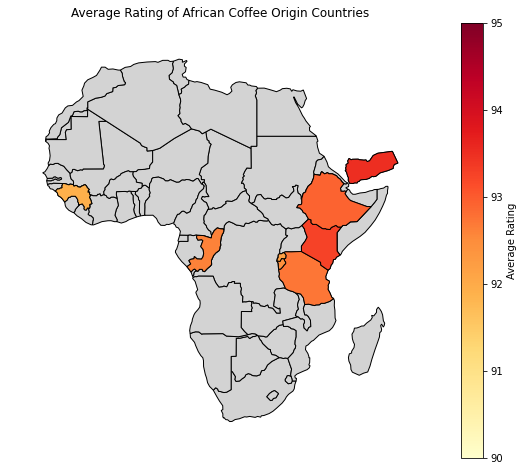

In [258]:
# Africa plot 
fig, ax = plt.subplots(figsize=(10,8))

africa = countries.query('continent == "Africa"')
yemen = countries[countries.name == "Yemen"]
africa = africa.append(yemen)

africa_df = pd.DataFrame()
rating_dict_africa = {}
        
for country in africa.name:
    if country.lower() in list(map(lambda s: s.lower().strip(), origins_df_filt["Country"].values.tolist())):
        country_df = origins_df_filt[origins_df_filt["Country"] == country]
        rating_dict_africa[country] = country_df["Average Rating"].values[0]    
        africa_df = africa_df.append(country_df)
        
review_countries_africa = africa[africa.name.isin(origins_df_filt["Country"].values.tolist())]

norm = plt.Normalize(vmin=90, vmax=95)
cmap = plt.cm.ScalarMappable(norm=norm, cmap='YlOrRd')

geoplot.choropleth(review_countries_africa,hue=rating_dict_africa.values(), cmap=cmap.cmap,norm=norm, ax=ax);
geoplot.polyplot(africa,facecolor='lightgray',ax=ax);
cbar = ax.figure.colorbar(cmap)
cbar.set_label("Average Rating")
ax.title.set_text("Average Rating of African Coffee Origin Countries")

africa_reviews_df = pd.DataFrame()

for idx, review in coffee_df.iterrows():
    name = review["Coffee Origin"]
    found = False
    
    for country in africa.name:
        if country.lower().strip() in name.lower().strip():
            africa_reviews_df = africa_reviews_df.append(review)
            found = True
            break

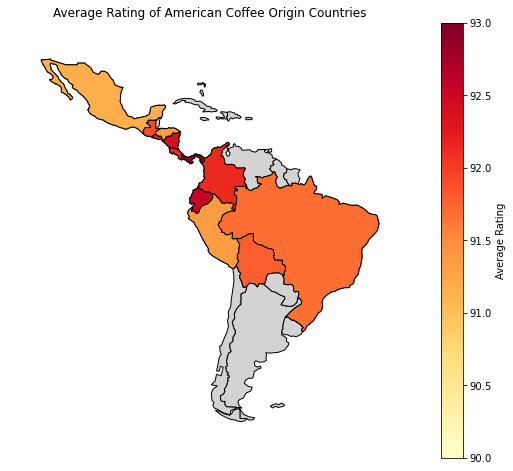

In [112]:
# North and South America plot
fig, ax = plt.subplots(figsize=(10,8))

SA = countries.query('continent == "South America"')
NA = countries.query('continent == "North America"')
NA = NA[countries.name != "United States of America"]
NA = NA[countries.name != "Canada"]
NA = NA[countries.name != "Greenland"]

america = NA.append(SA)

america_df = pd.DataFrame()
rating_dict_america = {}

for country in america.name:
    if country.lower() in list(map(lambda s: s.lower().strip(), origins_df_filt["Country"].values.tolist())):
        country_df = origins_df_filt[origins_df_filt["Country"] == country]
        rating_dict_america[country] = country_df["Average Rating"].values[0]    
        america_df = america_df.append(country_df)
        
review_countries_america = america[america.name.isin(origins_df_filt["Country"].values.tolist())]

norm = plt.Normalize(vmin=90, vmax=93)
cmap = plt.cm.ScalarMappable(norm=norm, cmap='YlOrRd')

geoplot.choropleth(review_countries_america,hue=rating_dict_america.values(), cmap=cmap.cmap,norm=norm, ax=ax);
geoplot.polyplot(america,facecolor='lightgray',
ax=ax);
cbar = ax.figure.colorbar(cmap)
cbar.set_label("Average Rating")
ax.title.set_text("Average Rating of American Coffee Origin Countries")

america_reviews_df = pd.DataFrame()

for idx, review in coffee_df.iterrows():
    name = review["Coffee Origin"]
    found = False
    
    for country in america.name:
        if country.lower().strip() in name.lower().strip():
            america_reviews_df = america_reviews_df.append(review)
            found = True
            break

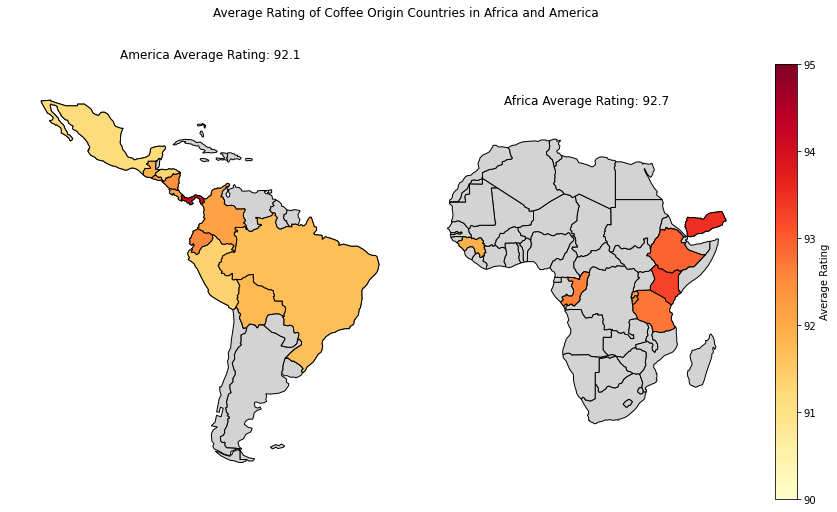

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(15,8))
plt.subplots_adjust(wspace=0, hspace=0)

norm = plt.Normalize(vmin=90, vmax=95)
cmap = plt.cm.ScalarMappable(norm=norm, cmap='YlOrRd')

geoplot.choropleth(review_countries_america,hue=rating_dict_america.values(), cmap=cmap.cmap,norm=norm, ax=axs[0]);
geoplot.polyplot(america,facecolor='lightgray',
ax=axs[0]);
axs[0].set_title("America Average Rating: " + str(round(america_df["Average Rating"].mean(), 1)))

geoplot.choropleth(review_countries_africa,hue=rating_dict_africa.values(), cmap=cmap.cmap,norm=norm, ax=axs[1]);
geoplot.polyplot(africa,facecolor='lightgray',ax=axs[1]);
axs[1].set_title("Africa Average Rating: " + str(round(africa_df["Average Rating"].mean(), 1)))

cbar = fig.colorbar(cmap)
cbar.set_label("Average Rating")
fig.suptitle("Average Rating of Coffee Origin Countries in Africa and America");

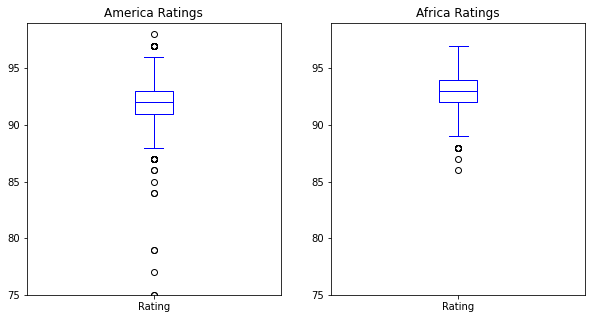

In [177]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
america_reviews_df["Rating"].plot(kind="box", ax=axs[0], color="blue");
africa_reviews_df["Rating"].plot(kind="box", ax=axs[1], color="blue");

axs[0].set_ylim([75,99]);
axs[1].set_ylim([75,99]);
axs[0].set_title("America Ratings");
axs[1].set_title("Africa Ratings");

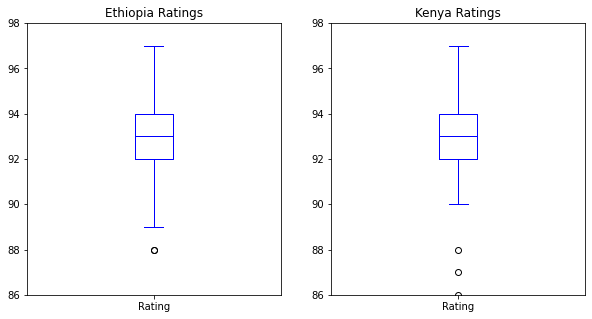

In [197]:
# Analyzing country-by-country
fig, axs = plt.subplots(1, 2, figsize=(10,5))

ethiopia_df = coffee_df[coffee_df["Coffee Origin"] == "Ethiopia"]
kenya_df = coffee_df[coffee_df["Coffee Origin"] == "Kenya"]

ethiopia_df["Rating"].plot(kind="box", ax=axs[0], color="blue");
kenya_df["Rating"].plot(kind="box", ax=axs[1], color="blue");
axs[0].set_ylim([86,98]);
axs[1].set_ylim([86,98]);
axs[0].set_title("Ethiopia Ratings");
axs[1].set_title("Kenya Ratings");

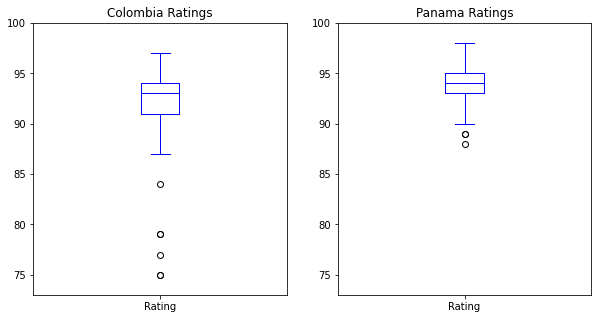

In [192]:
# Analyzing country-by-country
fig, axs = plt.subplots(1, 2, figsize=(10,5))

colombia_df = coffee_df[coffee_df["Coffee Origin"] == "Colombia"]
panama_df = coffee_df[coffee_df["Coffee Origin"] == "Panama"]

colombia_df["Rating"].plot(kind="box", ax=axs[0], color="blue");
panama_df["Rating"].plot(kind="box", ax=axs[1], color="blue");
axs[0].set_ylim([73,100]);
axs[1].set_ylim([73,100]);
axs[0].set_title("Colombia Ratings");
axs[1].set_title("Panama Ratings");


### Classification

In [281]:
# Classification models to predict coffee origin country, roaster, and rating from roast level and price of a coffee

# Regression model for predicting rating
rating_ols = sm.ols(formula="Rating ~ Roast_Level_num + DollarsPerOz", data=coffee_df).fit()
params = rating_ols.params
intercept = params[0]
roast_slope = params[1]
price_slope = params[2]

In [282]:
# Classification model for predicting coffee origin country
predicts = coffee_df[["Roast_Level_num", "DollarsPerOz"]].values
origins = coffee_df["Coffee Origin"].values


best_C = 50
svm_origins = svm.SVC(kernel='rbf', C = best_C,gamma='scale');
svm_origins.fit(predicts, origins);

In [283]:
# Classification model for predicting roaster
predicts = coffee_df[["Roast_Level_num", "DollarsPerOz"]].values
roasters = coffee_df["Roaster"].values

best_C = 0.1
svm_roasters = svm.SVC(kernel='rbf', C = best_C,gamma='scale');
svm_roasters.fit(predicts, roasters);

In [284]:
# Function to predict roaster, origin country, and rating from roast level and price
def predict(roast_level, price):
    priceperoz = price / 8 # assume an 8 oz. drink
        
    inputs = np.array([roast_level, priceperoz]).reshape(1, -1)
    roaster = svm_roasters.predict(inputs)[0]
    origin = svm_origins.predict(inputs)[0]
    rating = intercept + roast_slope * roast_level + price_slope * priceperoz
    rating = svm_ratings.predict(inputs)[0]
    return [roaster, origin, rating]

### Coffee Predictor Program

In [299]:
# Tkinter Program

from tkinter import *
from tkinter import messagebox
import tkinter as tk

def getPredictions ():
    continue_bool = True
    try:
        roast_level = int(input1.get())

        if roast_level < 0 or roast_level > 4:
            raise ValueError()

    except ValueError:
        continue_bool = False
        messagebox.showerror('Value Error', "Error: input for roast level must be an integer between 0 and 4")
    if continue_bool:
        try:
            price = float(input2.get())
            if price <= 0:
                raise ValueError()
        except ValueError:
            messagebox.showerror('Value Error', "Error: price must be greater than $0")
            continue_bool = False
        if continue_bool:
            inputs = np.array([roast_level, price]).reshape(1, -1)
            roaster = svm_roasters.predict(inputs)[0]
            origin = svm_origins.predict(inputs)[0]
            rating = intercept + roast_slope * roast_level + price_slope * price
            if rating > 100:
                rating = 100
            
            result4 = tk.Label(root, text=origin, font=('helvetica', 11))
            result4.grid(row =4, column=0, pady = 2, padx = 1)
            result5 = tk.Label(root, text=roaster, font=('helvetica', 11))
            result5.grid(row =4, column=1, pady = 2, padx = 1)
            result6 = tk.Label(root, text=str(round(rating,2)), font=('helvetica', 11))
            result6.grid(row =4, column=2, pady = 2, padx = 1)            
            
root= tk.Tk()
root.title("Coffee Predictor")
root.geometry("600x200")
root.eval('tk::PlaceWindow . center')


label1 = tk.Label(root, text="Roast Level (0, 1, 2, 3, 4)",font=('helvetica', 10, 'bold'))
label1.grid(row =0, column=0, pady = 1, padx = 5)
label2 = tk.Label(root, text="Price Per Oz (> 0)",font=('helvetica', 10, 'bold'))
label2.grid(row=0, column=2, pady = 1, padx = 5)

input1 = tk.Entry(root)
input1.grid(row=1, column=0, pady = 5, padx = 5)
input2 = tk.Entry(root)
input2.grid(row=1, column=2, pady = 5, padx = 5)
button = tk.Button(text='Predict', command=getPredictions,  bg='red', fg='white', font=('helvetica', 9, 'bold'))
button.grid(row=2, column=1, pady = 20)

result1 = tk.Label(root, text="Origin Country",font=('helvetica', 10, 'bold'))
result1.grid(row =3, column=0, pady = 1, padx = 1)
result2 = tk.Label(root, text="Roaster", font=('helvetica', 10, 'bold'))
result2.grid(row =3, column=1, pady = 1, padx = 1)
result3 = tk.Label(root, text="Rating", font=('helvetica', 10, 'bold'))
result3.grid(row =3, column=2, pady = 1, padx = 1)

root.grid_columnconfigure((0, 2), weight=1)

root.mainloop()

## Results

A summary of the results of the project

## Evaluation

What are the metrics used to evaluate how successful your project is?

## Project Summary

Answer specific questions below using only 1-2 sentences:

What is an overview of your project?

What are your project objectives?

What are your technical contributions?

What are the main results?

How are the results evaluated?

What are the future directions?